<a href="https://colab.research.google.com/github/NinaAbeyratne/domain-shift-medical-segmentation/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Base directory
BASE_DIR = Path('/content/drive/MyDrive/MV CW/V2')
DATA_DIR = BASE_DIR / 'data' / 'processed'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

for p in [BASE_DIR, DATA_DIR, MODELS_DIR, RESULTS_DIR]: print(f"{p}")

print("Models dir exists:", MODELS_DIR.exists())
print("Files in models dir:", list(MODELS_DIR.glob("*")))

/content/drive/MyDrive/MV CW/V2
/content/drive/MyDrive/MV CW/V2/data/processed
/content/drive/MyDrive/MV CW/V2/models
/content/drive/MyDrive/MV CW/V2/results
Models dir exists: True
Files in models dir: [PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_best.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch5.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch8.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch10.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch15.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch20.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/training_history.pkl')]


In [7]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

In [8]:
# Create output directory
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("Files in models dir:", list(MODELS_DIR.glob("*")))

Files in models dir: [PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_best.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch5.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch8.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch10.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch15.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/unet_epoch20.pth'), PosixPath('/content/drive/MyDrive/MV CW/V2/models/training_history.pkl')]


## Load Trained Model and Data

### Model definition

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        enc1 = self.enc1(x); p1 = self.pool1(enc1)
        enc2 = self.enc2(p1); p2 = self.pool2(enc2)
        enc3 = self.enc3(p2); p3 = self.pool3(enc3)
        enc4 = self.enc4(p3); p4 = self.pool4(enc4)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b); d4 = self.dec4(torch.cat([u4, enc4], dim=1))
        u3 = self.upconv3(d4); d3 = self.dec3(torch.cat([u3, enc3], dim=1))
        u2 = self.upconv2(d3); d2 = self.dec2(torch.cat([u2, enc2], dim=1))
        u1 = self.upconv1(d2); d1 = self.dec1(torch.cat([u1, enc1], dim=1))

        out = self.out(d1)
        return self.sigmoid(out)

### Load model

In [10]:
print((MODELS_DIR / 'unet_epoch8.pth').exists())

True


In [12]:
# Load model
model = UNet(in_channels=1, out_channels=1).to(device)

checkpoint = torch.load(MODELS_DIR / 'unet_epoch8.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

print(f"Model loaded from epoch {checkpoint.get('epoch', 'N/A')}")

Model loaded from epoch 8


### Load Data

In [13]:
# ensure [N,1,256,256] and per-image normalization
def ensure_channel_first(arr):
    # Expect arr as [N, H, W] or [N, 1, H, W]
    if arr.ndim == 3:          # [N, H, W]
        arr = arr[:, np.newaxis, :, :]
    elif arr.ndim == 4:
        # If [N, C, H, W] and C==1, keep; if [N,1,1,H,W] you should squeeze elsewhere
        pass
    else:
        raise ValueError(f"Unexpected array shape: {arr.shape}")
    return arr

In [14]:
def normalize_image(img):
    # img: [1, H, W] numpy
    # Per-image standardization: (x - mean) / (std + eps)
    eps = 1e-6
    mean = img.mean()
    std = img.std()
    return (img - mean) / (std + eps)

In [15]:
class MedicalSegmentationDataset(Dataset):
    def __init__(self, images, masks, apply_normalization=True):
        # images, masks as numpy [N,1,H,W]
        assert images.shape == masks.shape, f"Image/Mask shape mismatch: {images.shape} vs {masks.shape}"
        assert images.shape[1] == 1 and masks.shape[1] == 1, f"Expected single-channel. Got {images.shape} and {masks.shape}"
        self.images = images.astype(np.float32)
        self.masks = masks.astype(np.float32)
        # Ensure masks are {0,1}
        self.masks = np.clip(self.masks, 0.0, 1.0)
        self.apply_normalization = apply_normalization

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]     # [1,H,W]
        mask  = self.masks[idx]      # [1,H,W]

        if self.apply_normalization:
            image = normalize_image(image)

        # Final check shapes
        assert image.ndim == 3 and mask.ndim == 3, f"Expected [1,H,W], got {image.shape} {mask.shape}"

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [16]:
# Load numpy arrays
synthetic_val_images = np.load(DATA_DIR / 'synthetic_val_images.npy')
synthetic_val_masks  = np.load(DATA_DIR / 'synthetic_val_masks.npy')

real_test_images = np.load(DATA_DIR / 'real_test_images.npy')
real_test_masks  = np.load(DATA_DIR / 'real_test_masks.npy')

montgomery_images = np.load(DATA_DIR / 'montgomery_images.npy')
montgomery_masks  = np.load(DATA_DIR / 'montgomery_masks.npy')

In [17]:
# To maintain shape [N,1,256,256]
synthetic_val_images = ensure_channel_first(synthetic_val_images)
synthetic_val_masks  = ensure_channel_first(synthetic_val_masks)

real_test_images = ensure_channel_first(real_test_images)
real_test_masks  = ensure_channel_first(real_test_masks)

montgomery_images = ensure_channel_first(montgomery_images)
montgomery_masks  = ensure_channel_first(montgomery_masks)

In [18]:
# check shapes
print("\nDataset shapes after channel enforcement:")
print(f"Synthetic:  images {synthetic_val_images.shape}, masks {synthetic_val_masks.shape}")
print(f"Real:       images {real_test_images.shape}, masks {real_test_masks.shape}")
print(f"Montgomery: images {montgomery_images.shape}, masks {montgomery_masks.shape}")


Dataset shapes after channel enforcement:
Synthetic:  images (100, 1, 256, 256), masks (100, 1, 256, 256)
Real:       images (150, 1, 256, 256), masks (150, 1, 256, 256)
Montgomery: images (20, 1, 256, 256), masks (20, 1, 256, 256)


In [19]:
# Create datasets/loaders
batch_size = 16
synthetic_val_dataset = MedicalSegmentationDataset(synthetic_val_images, synthetic_val_masks, apply_normalization=True)
real_test_dataset     = MedicalSegmentationDataset(real_test_images, real_test_masks, apply_normalization=True)
montgomery_dataset    = MedicalSegmentationDataset(montgomery_images, montgomery_masks, apply_normalization=True)

synthetic_val_loader = DataLoader(synthetic_val_dataset, batch_size=batch_size, shuffle=False)
real_test_loader     = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=False)
montgomery_loader    = DataLoader(montgomery_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# check batch
x_syn, y_syn = next(iter(synthetic_val_loader))
x_real, y_real = next(iter(real_test_loader))
x_mont, y_mont = next(iter(montgomery_loader))
print("\  (batch shapes):")
print("Synthetic:", tuple(x_syn.shape), tuple(y_syn.shape))
print("Real:",      tuple(x_real.shape), tuple(y_real.shape))
print("Montgomery:",tuple(x_mont.shape), tuple(y_mont.shape))
assert x_syn.ndim == 4 and x_syn.shape[1] == 1 and x_syn.shape[2:] == (256,256), "Batch shape must be [B,1,256,256]"

\  (batch shapes):
Synthetic: (16, 1, 256, 256) (16, 1, 256, 256)
Real: (16, 1, 256, 256) (16, 1, 256, 256)
Montgomery: (16, 1, 256, 256) (16, 1, 256, 256)


### Evaluation Metrics

### Dice

In [21]:
def calculate_dice_coefficient(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    smooth = 1e-5
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return dice.item()

### IoU

In [22]:
def calculate_iou(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    smooth = 1e-5
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

### Evaluate Baseline Model

In [23]:
def evaluate_model(model, loader, device):
    model.eval()
    all_dice, all_iou = [], []
    all_predictions, all_targets, all_images = [], [], []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            for i in range(images.size(0)):
                pred = outputs[i:i+1]
                target = masks[i:i+1]

                dice = calculate_dice_coefficient(pred, target)
                iou = calculate_iou(pred, target)

                all_dice.append(dice)
                all_iou.append(iou)

                all_predictions.append(pred.cpu().numpy())
                all_targets.append(target.cpu().numpy())
                all_images.append(images[i:i+1].cpu().numpy())

    metrics = {
        'dice_scores': all_dice,
        'iou_scores': all_iou,
        'mean_dice': float(np.mean(all_dice)),
        'std_dice': float(np.std(all_dice)),
        'mean_iou': float(np.mean(all_iou)),
        'std_iou': float(np.std(all_iou)),
        'predictions': all_predictions,
        'targets': all_targets,
        'images': all_images
    }
    return metrics

print("\nEvaluating on Synthetic Validation Set...")
synthetic_metrics = evaluate_model(model, synthetic_val_loader, device)

print("\nEvaluating on Real Test Set...")
real_metrics = evaluate_model(model, real_test_loader, device)

print("\nEvaluating on Montgomery Dataset...")
montgomery_metrics = evaluate_model(model, montgomery_loader, device)


Evaluating on Synthetic Validation Set...


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]



Evaluating on Real Test Set...


Evaluating: 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]



Evaluating on Montgomery Dataset...


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


### Baseline Results

In [27]:
print("\nBASELINE RESULTS")
print("\n Synthetic Validation Set (In-Domain):")
print(f"  Mean Dice: {synthetic_metrics['mean_dice']:.4f} ± {synthetic_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {synthetic_metrics['mean_iou']:.4f} ± {synthetic_metrics['std_iou']:.4f}")

print("\n Real Test Set (Cross-Domain):")
print(f"  Mean Dice: {real_metrics['mean_dice']:.4f} ± {real_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {real_metrics['mean_iou']:.4f} ± {real_metrics['std_iou']:.4f}")

print("\n Montgomery Dataset (Cross-Domain):")
print(f"  Mean Dice: {montgomery_metrics['mean_dice']:.4f} ± {montgomery_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {montgomery_metrics['mean_iou']:.4f} ± {montgomery_metrics['std_iou']:.4f}")


BASELINE RESULTS

 Synthetic Validation Set (In-Domain):
  Mean Dice: 1.0000 ± 0.0000
  Mean IoU:  1.0000 ± 0.0001

 Real Test Set (Cross-Domain):
  Mean Dice: 0.9901 ± 0.0055
  Mean IoU:  0.9804 ± 0.0108

 Montgomery Dataset (Cross-Domain):
  Mean Dice: 0.0465 ± 0.0878
  Mean IoU:  0.0261 ± 0.0512


In [28]:
# Performance drop
dice_drop_real = synthetic_metrics['mean_dice'] - real_metrics['mean_dice']
dice_drop_real_pct = (dice_drop_real / max(synthetic_metrics['mean_dice'], 1e-6)) * 100
dice_drop_mont = synthetic_metrics['mean_dice'] - montgomery_metrics['mean_dice']
dice_drop_mont_pct = (dice_drop_mont / max(synthetic_metrics['mean_dice'], 1e-6)) * 100

print("\n Performance Degradation (Cross-Domain):")
print(f"  Synthetic → Real:       {dice_drop_real:.4f} ({dice_drop_real_pct:.1f}%)")
print(f"  Synthetic → Montgomery: {dice_drop_mont:.4f} ({dice_drop_mont_pct:.1f}%)")


 Performance Degradation (Cross-Domain):
  Synthetic → Real:       0.0099 (1.0%)
  Synthetic → Montgomery: 0.9535 (95.4%)


In [29]:
x, y = next(iter(synthetic_val_loader))
print(x.shape, y.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


# Visualization

In [30]:
def visualize_predictions(images, targets, predictions, indices, title, save_path):
    n_samples = len(indices)
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        image = images[idx].squeeze()        # [H,W]
        target = targets[idx].squeeze()      # [H,W]
        pred = predictions[idx].squeeze()    # [H,W]
        pred_binary = (pred > 0.5).astype(float)

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Input Image'); axes[i, 0].axis('off')

        axes[i, 1].imshow(target, cmap='gray')
        axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='jet', vmin=0, vmax=1)
        axes[i, 2].set_title('Prediction (Probability)'); axes[i, 2].axis('off')

        axes[i, 3].imshow(pred_binary, cmap='gray')
        dice = calculate_dice_coefficient(torch.FloatTensor(pred[np.newaxis, np.newaxis, ...]),
                                          torch.FloatTensor(target[np.newaxis, np.newaxis, ...]))
        axes[i, 3].set_title(f'Binary Prediction\nDice: {dice:.3f}')
        axes[i, 3].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / save_path, dpi=150, bbox_inches='tight')
    plt.show()


VISUALIZING PREDICTIONS


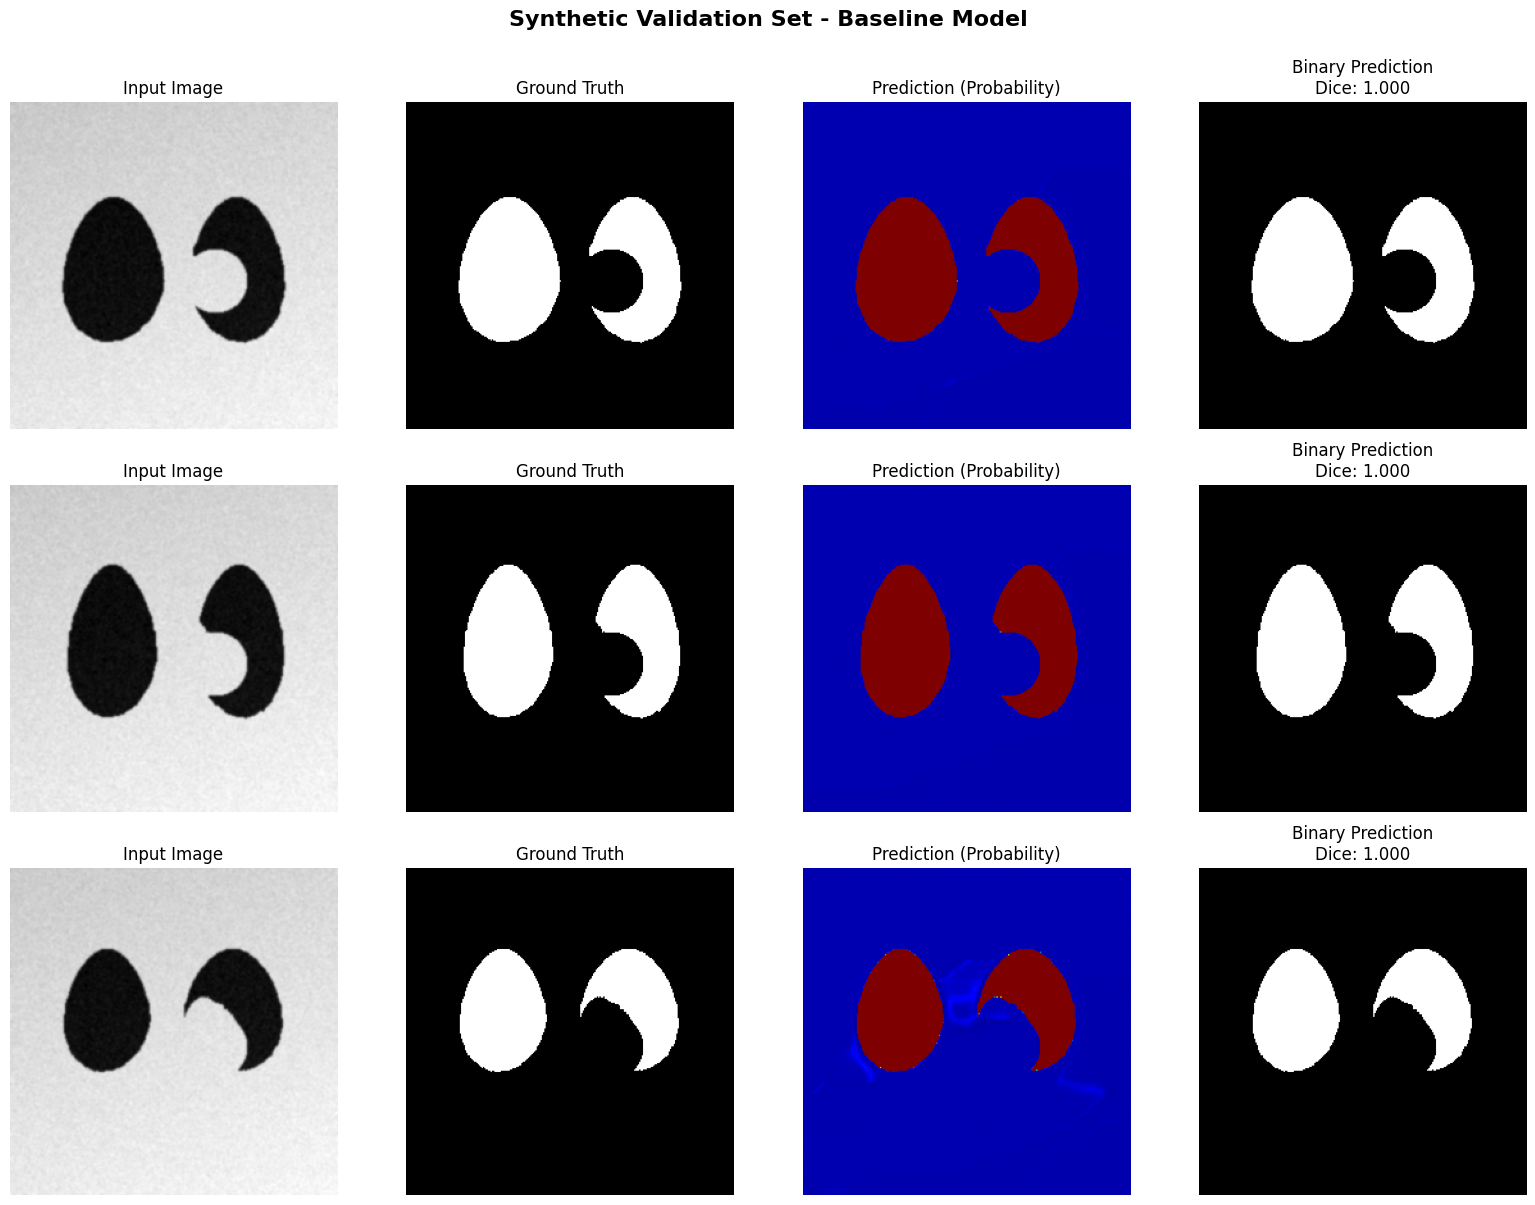

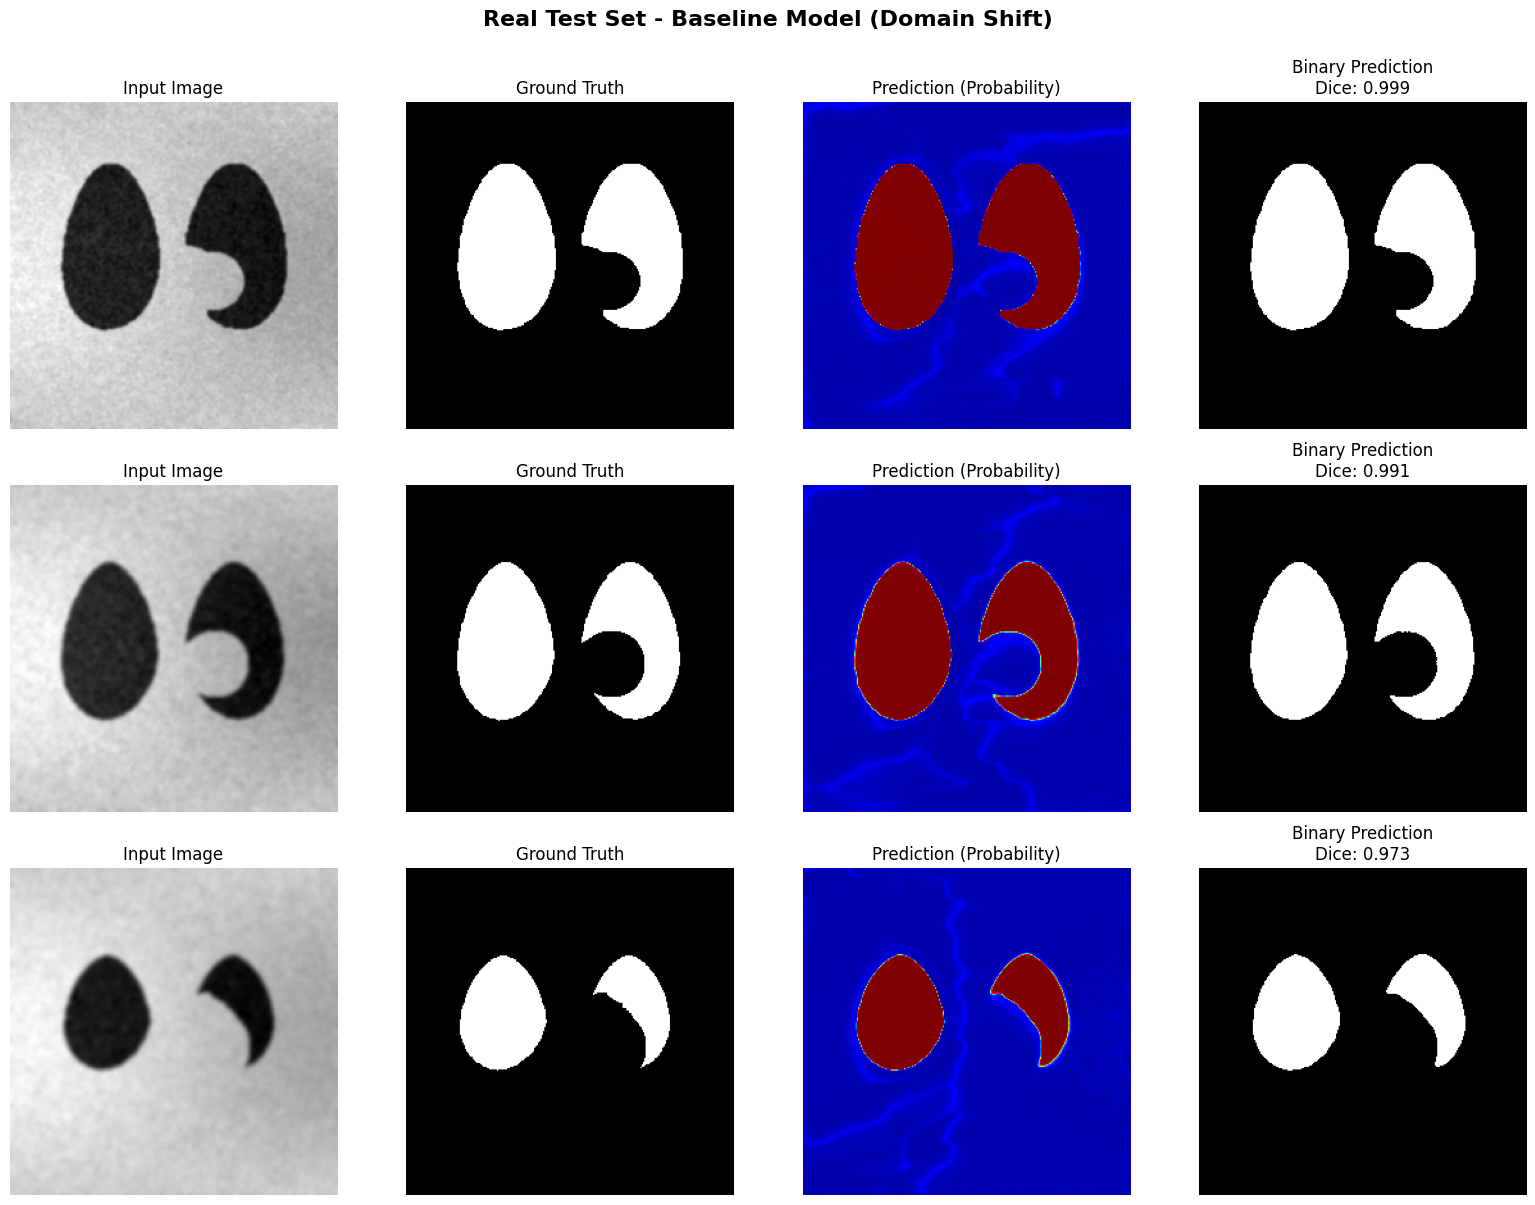

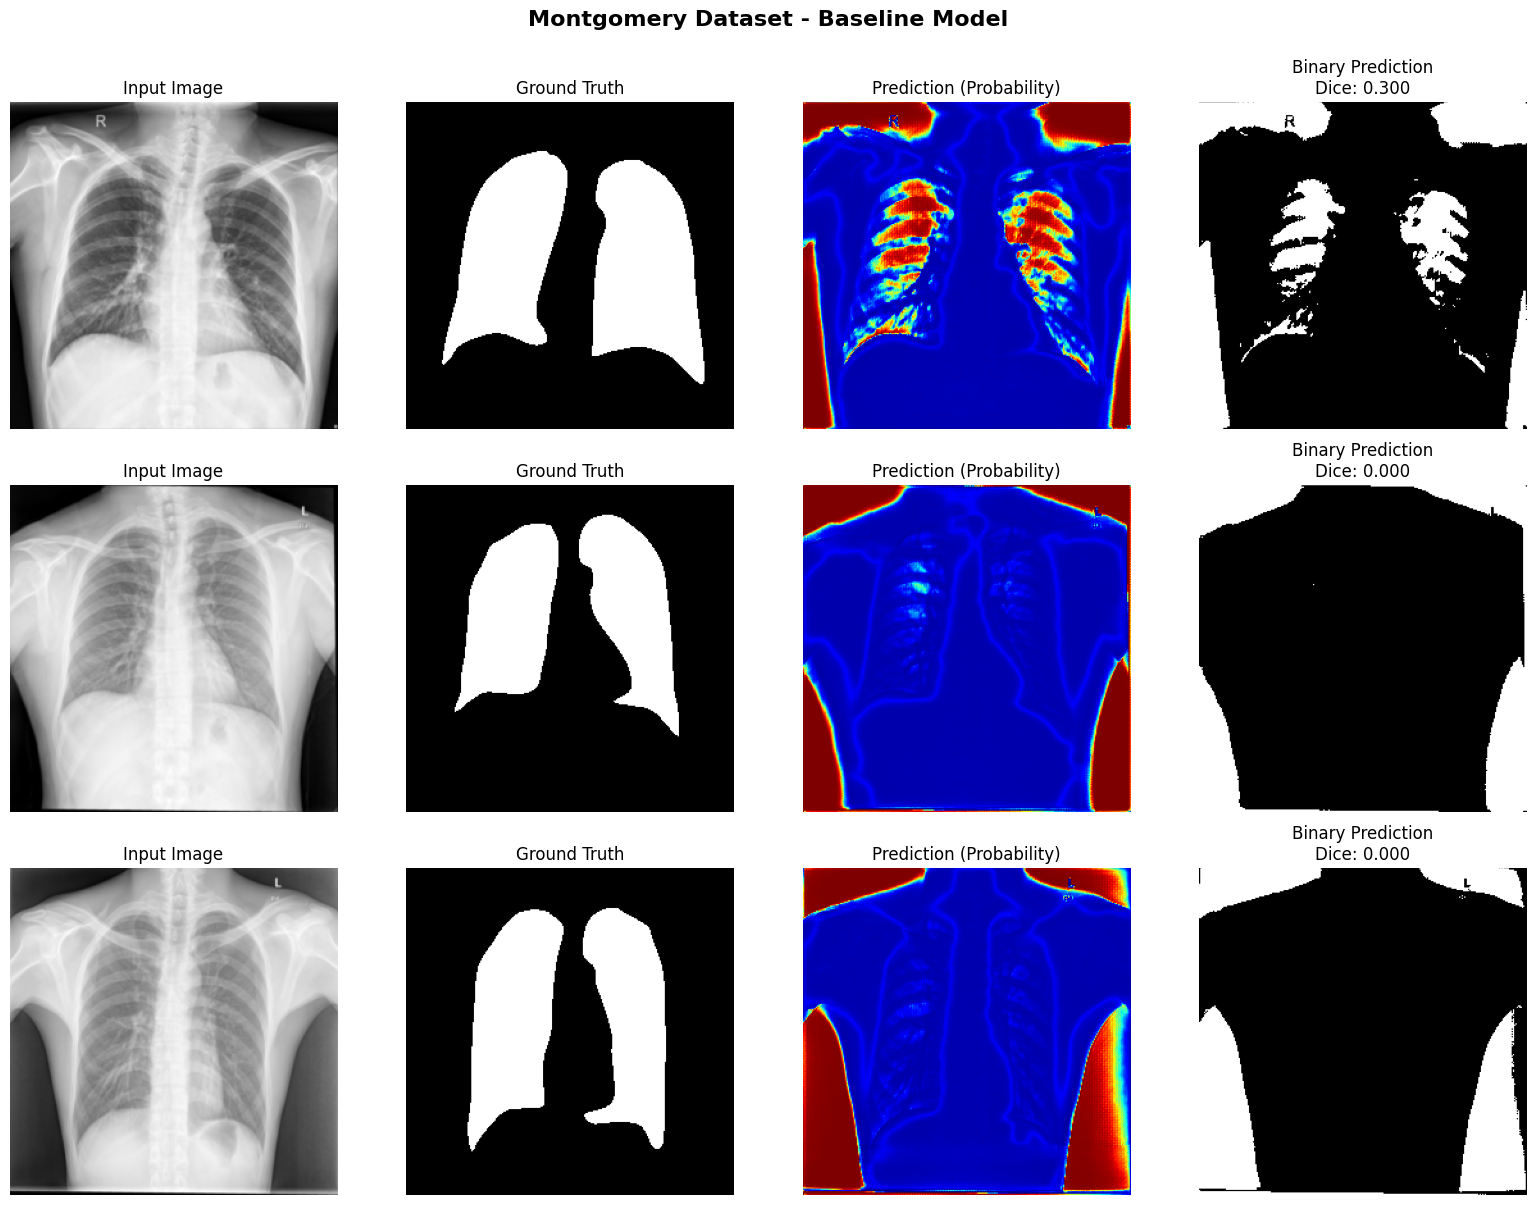


Visualizations saved to results/


In [31]:
print("\nVISUALIZING PREDICTIONS")

# Synthetic examples: best, median, worst
syn_sorted_idx = np.argsort(synthetic_metrics['dice_scores'])
syn_samples = [syn_sorted_idx[-1], syn_sorted_idx[len(syn_sorted_idx)//2], syn_sorted_idx[0]]
visualize_predictions(synthetic_metrics['images'], synthetic_metrics['targets'], synthetic_metrics['predictions'],
                      syn_samples, 'Synthetic Validation Set - Baseline Model', 'synthetic_predictions_baseline.png')

# Real examples
real_sorted_idx = np.argsort(real_metrics['dice_scores'])
real_samples = [real_sorted_idx[-1], real_sorted_idx[len(real_sorted_idx)//2], real_sorted_idx[0]]
visualize_predictions(real_metrics['images'], real_metrics['targets'], real_metrics['predictions'],
                      real_samples, 'Real Test Set - Baseline Model (Domain Shift)', 'real_predictions_baseline.png')

# Montgomery examples
mont_sorted_idx = np.argsort(montgomery_metrics['dice_scores'])
mont_samples = [mont_sorted_idx[-1], mont_sorted_idx[len(mont_sorted_idx)//2], mont_sorted_idx[0]]
visualize_predictions(montgomery_metrics['images'], montgomery_metrics['targets'], montgomery_metrics['predictions'],
                      mont_samples, 'Montgomery Dataset - Baseline Model', 'montgomery_predictions_baseline.png')

print("\nVisualizations saved to results/")

# Domain Shift Analysis

Domain
Real          150
Synthetic     100
Montgomery     20
Name: count, dtype: int64


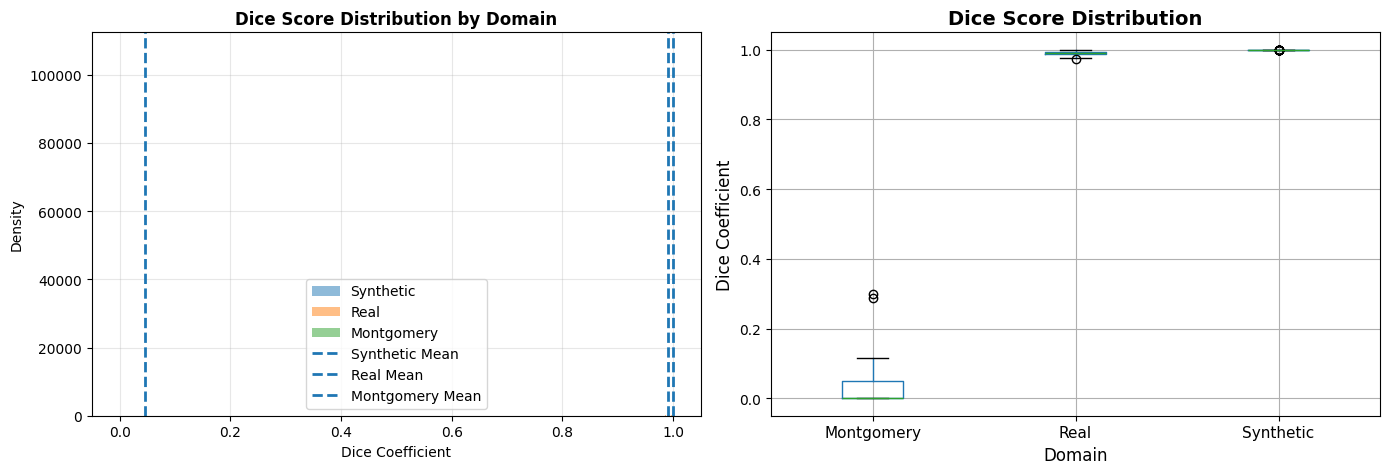


Domain shift analysis saved.


In [32]:
# Domain shift analysis (histograms + boxplots)
df_synthetic = pd.DataFrame({'Dice': synthetic_metrics['dice_scores'], 'IoU': synthetic_metrics['iou_scores'], 'Domain': 'Synthetic'})
df_real      = pd.DataFrame({'Dice': real_metrics['dice_scores'],      'IoU': real_metrics['iou_scores'],      'Domain': 'Real'})
df_mont      = pd.DataFrame({'Dice': montgomery_metrics['dice_scores'],'IoU': montgomery_metrics['iou_scores'],'Domain': 'Montgomery'})
df_combined  = pd.concat([df_synthetic, df_real, df_mont], ignore_index=True)

print(df_combined['Domain'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(synthetic_metrics['dice_scores'], bins=30, alpha=0.5, label='Synthetic', density=True)
axes[0].hist(real_metrics['dice_scores'],      bins=30, alpha=0.5, label='Real',      density=True)
axes[0].hist(montgomery_metrics['dice_scores'],bins=30, alpha=0.5, label='Montgomery',density=True)

axes[0].axvline(synthetic_metrics['mean_dice'], linestyle='--', linewidth=2, label='Synthetic Mean')
axes[0].axvline(real_metrics['mean_dice'],      linestyle='--', linewidth=2, label='Real Mean')
axes[0].axvline(montgomery_metrics['mean_dice'],linestyle='--', linewidth=2, label='Montgomery Mean')

axes[0].set_xlabel('Dice Coefficient'); axes[0].set_ylabel('Density')
axes[0].set_title('Dice Score Distribution by Domain', fontweight='bold')
axes[0].legend(); axes[0].grid(alpha=0.3)

df_combined.boxplot(column='Dice', by='Domain', ax=axes[1])
axes[1].set_xlabel('Domain', fontsize=12); axes[1].set_ylabel('Dice Coefficient', fontsize=12)
axes[1].set_title('Dice Score Distribution', fontsize=14, fontweight='bold')
axes[1].get_figure().suptitle(''); plt.sca(axes[1]); plt.xticks(fontsize=11)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'domain_shift_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDomain shift analysis saved.")

# Domain Adaptation Strategy

In [33]:
def tta_inference(model, image, device, n_aug=5):
    # image: [1,1,H,W] torch
    model.eval()
    preds = []

    with torch.no_grad():
        # Original
        preds.append(model(image))

        # Add light noise
        for _ in range(n_aug - 1):
            noise = torch.randn_like(image) * 0.05
            preds.append(model(image + noise))

        # Simple flips TTA
        flipped_h = torch.flip(image, dims=[-2])
        flipped_w = torch.flip(image, dims=[-1])
        preds.append(torch.flip(model(flipped_h), dims=[-2]))
        preds.append(torch.flip(model(flipped_w), dims=[-1]))

    return torch.mean(torch.stack(preds), dim=0)

In [34]:
def evaluate_model_with_adaptation(model, loader, device):
    model.eval()
    all_dice, all_iou = [], []
    all_predictions, all_targets, all_images = [], [], []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Evaluating (with TTA)'):
            images = images.to(device)
            masks = masks.to(device)

            for i in range(images.size(0)):
                img = images[i:i+1]
                tgt = masks[i:i+1]

                pred = tta_inference(model, img, device, n_aug=5)

                dice = calculate_dice_coefficient(pred, tgt)
                iou  = calculate_iou(pred, tgt)

                all_dice.append(dice); all_iou.append(iou)
                all_predictions.append(pred.cpu().numpy())
                all_targets.append(tgt.cpu().numpy())
                all_images.append(img.cpu().numpy())

    metrics = {
        'dice_scores': all_dice,
        'iou_scores': all_iou,
        'mean_dice': float(np.mean(all_dice)),
        'std_dice': float(np.std(all_dice)),
        'mean_iou': float(np.mean(all_iou)),
        'std_iou': float(np.std(all_iou)),
        'predictions': all_predictions,
        'targets': all_targets,
        'images': all_images
    }
    return metrics

In [35]:
print("\nEvaluating with Domain Adaptation on Real and Montgomery...")
real_metrics_improved = evaluate_model_with_adaptation(model, real_test_loader, device)
mont_metrics_improved = evaluate_model_with_adaptation(model, montgomery_loader, device)


Evaluating with Domain Adaptation on Real and Montgomery...


Evaluating (with TTA): 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


In [37]:
print("\nIMPROVED RESULTS (WITH TTA)")
print("\n Real Test Set (Baseline):")
print(f"  Mean Dice: {real_metrics['mean_dice']:.4f} ± {real_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {real_metrics['mean_iou']:.4f} ± {real_metrics['std_iou']:.4f}")

print("\n Real Test Set (With TTA):")
print(f"  Mean Dice: {real_metrics_improved['mean_dice']:.4f} ± {real_metrics_improved['std_dice']:.4f}")
print(f"  Mean IoU:  {real_metrics_improved['mean_iou']:.4f} ± {real_metrics_improved['std_iou']:.4f}")


IMPROVED RESULTS (WITH TTA)

 Real Test Set (Baseline):
  Mean Dice: 0.9901 ± 0.0055
  Mean IoU:  0.9804 ± 0.0108

 Real Test Set (With TTA):
  Mean Dice: 0.9900 ± 0.0055
  Mean IoU:  0.9803 ± 0.0108


In [38]:
dice_gain_real = real_metrics_improved['mean_dice'] - real_metrics['mean_dice']
dice_gain_real_pct = (dice_gain_real / max(real_metrics['mean_dice'], 1e-6)) * 100
print(f"\n Real improvement: Dice +{dice_gain_real:.4f} ({dice_gain_real_pct:.1f}% relative)")


 Real improvement: Dice +-0.0000 (-0.0% relative)


In [39]:
print("\n Montgomery (Baseline):")
print(f"  Mean Dice: {montgomery_metrics['mean_dice']:.4f} ± {montgomery_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {montgomery_metrics['mean_iou']:.4f} ± {montgomery_metrics['std_iou']:.4f}")

print("\n Montgomery (With TTA):")
print(f"  Mean Dice: {mont_metrics_improved['mean_dice']:.4f} ± {mont_metrics_improved['std_dice']:.4f}")
print(f"  Mean IoU:  {mont_metrics_improved['mean_iou']:.4f} ± {mont_metrics_improved['std_iou']:.4f}")


 Montgomery (Baseline):
  Mean Dice: 0.0465 ± 0.0878
  Mean IoU:  0.0261 ± 0.0512

 Montgomery (With TTA):
  Mean Dice: 0.0479 ± 0.0895
  Mean IoU:  0.0269 ± 0.0524


In [40]:
dice_gain_mont = mont_metrics_improved['mean_dice'] - montgomery_metrics['mean_dice']
dice_gain_mont_pct = (dice_gain_mont / max(montgomery_metrics['mean_dice'], 1e-6)) * 100
print(f"\n Montgomery improvement: Dice +{dice_gain_mont:.4f} ({dice_gain_mont_pct:.1f}% relative)")


 Montgomery improvement: Dice +0.0014 (2.9% relative)


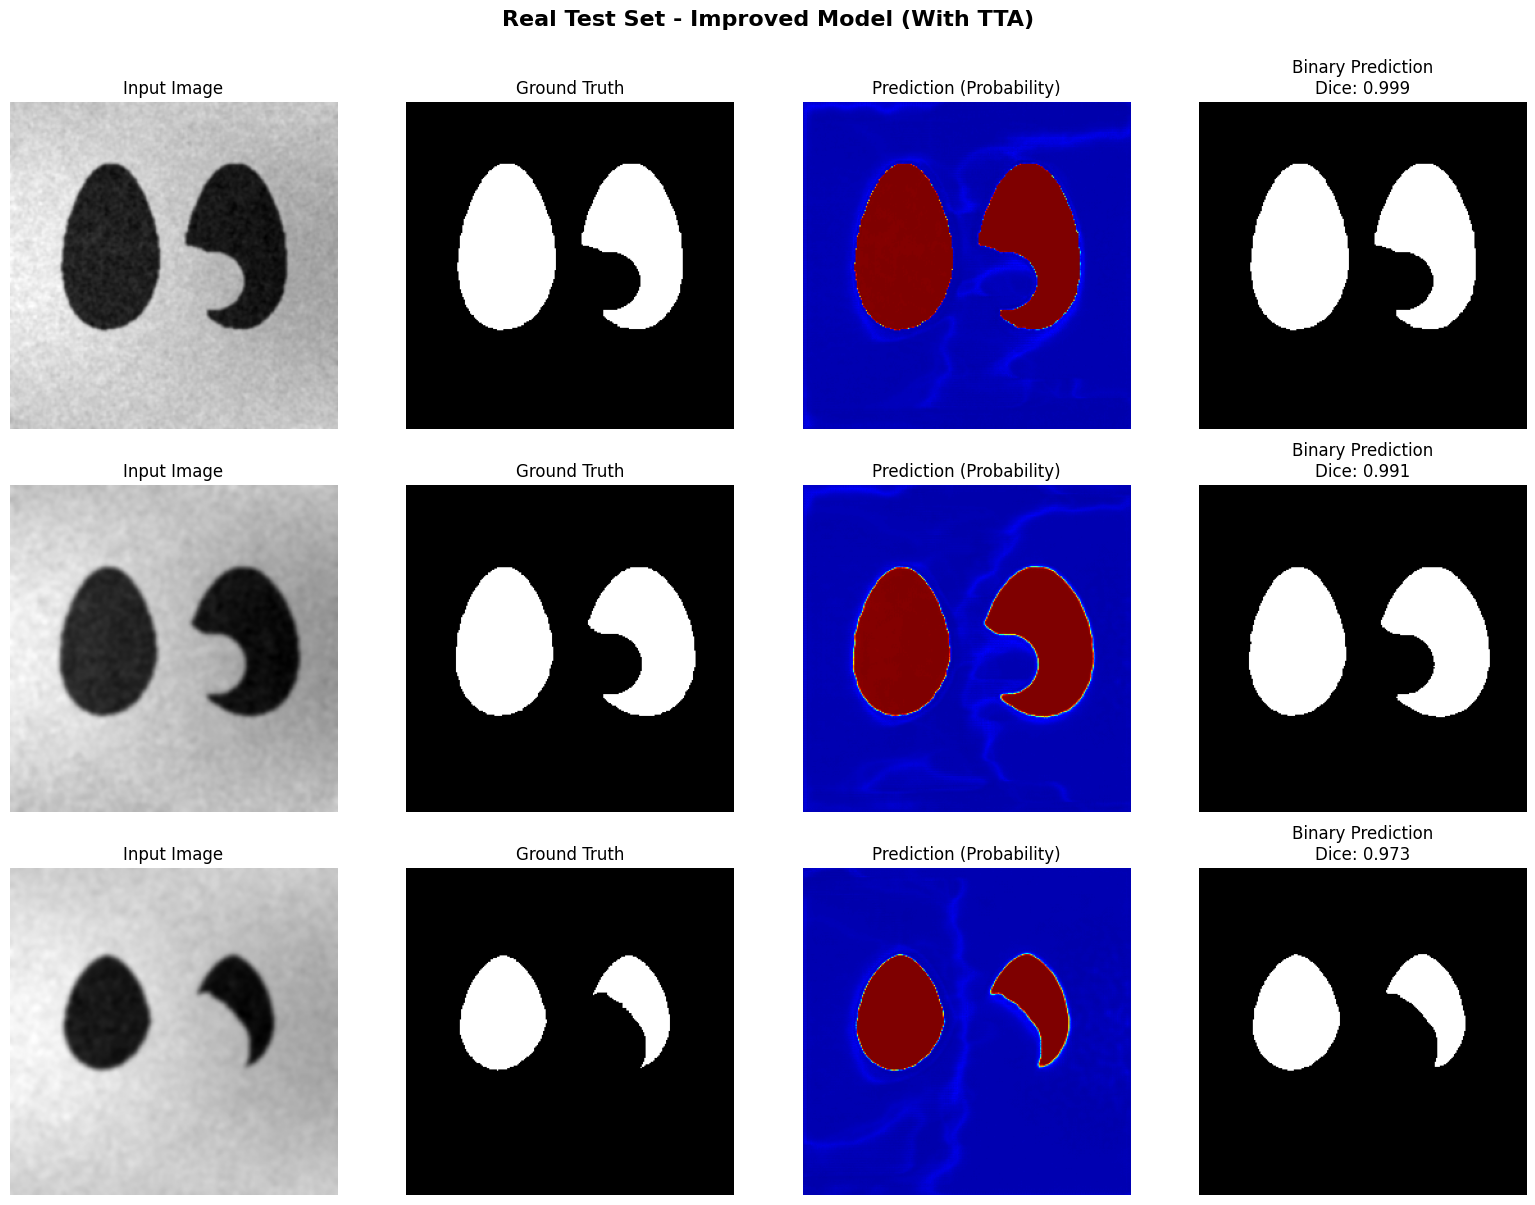

In [41]:
# Visualize improved predictions (Real)
real_sorted_idx_improved = np.argsort(real_metrics_improved['dice_scores'])
real_samples_improved = [real_sorted_idx_improved[-1],
                         real_sorted_idx_improved[len(real_sorted_idx_improved)//2],
                         real_sorted_idx_improved[0]]

visualize_predictions(real_metrics_improved['images'], real_metrics_improved['targets'], real_metrics_improved['predictions'],
                      real_samples_improved, 'Real Test Set - Improved Model (With TTA)',
                      'real_predictions_improved.png')

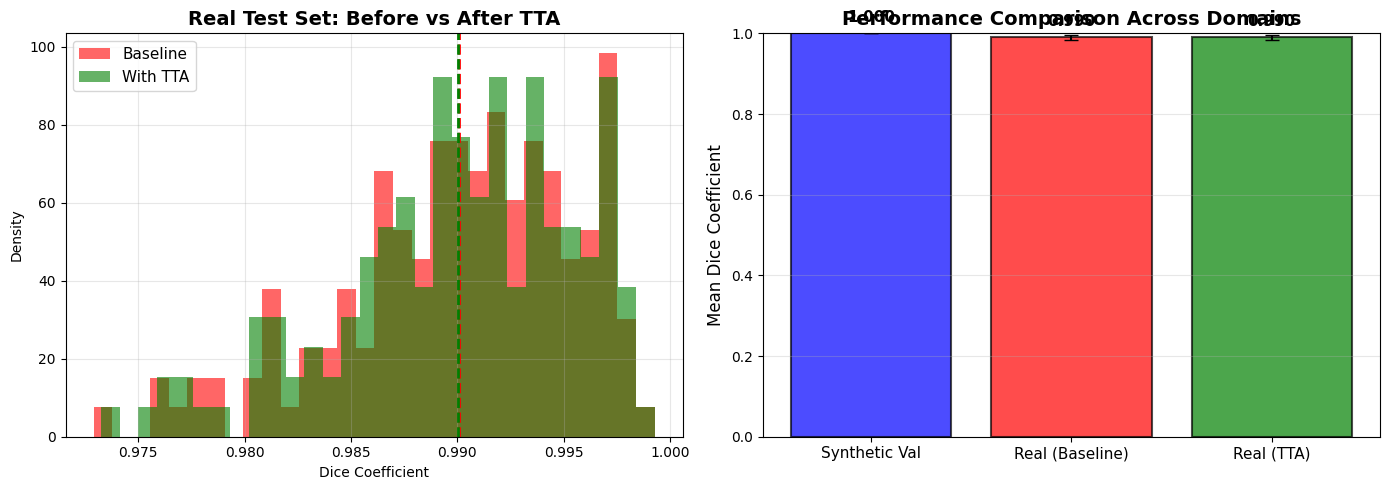


Comparison visualization saved.


In [42]:
# Before vs After comparison (Real)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(real_metrics['dice_scores'], bins=30, alpha=0.6, label='Baseline', color='red', density=True)
axes[0].hist(real_metrics_improved['dice_scores'], bins=30, alpha=0.6, label='With TTA', color='green', density=True)
axes[0].axvline(real_metrics['mean_dice'], color='red', linestyle='--', linewidth=2)
axes[0].axvline(real_metrics_improved['mean_dice'], color='green', linestyle='--', linewidth=2)
axes[0].set_xlabel('Dice Coefficient'); axes[0].set_ylabel('Density')
axes[0].set_title('Real Test Set: Before vs After TTA', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11); axes[0].grid(alpha=0.3)

metrics_comparison = {
    'Synthetic Val': [synthetic_metrics['mean_dice'], synthetic_metrics['std_dice']],
    'Real (Baseline)': [real_metrics['mean_dice'], real_metrics['std_dice']],
    'Real (TTA)': [real_metrics_improved['mean_dice'], real_metrics_improved['std_dice']]
}
x_pos = np.arange(len(metrics_comparison))
means = [v[0] for v in metrics_comparison.values()]
stds = [v[1] for v in metrics_comparison.values()]
colors = ['blue', 'red', 'green']
bars = axes[1].bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=1.5)
axes[1].set_xticks(x_pos); axes[1].set_xticklabels(metrics_comparison.keys(), fontsize=11)
axes[1].set_ylabel('Mean Dice Coefficient', fontsize=12)
axes[1].set_title('Performance Comparison Across Domains', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.0]); axes[1].grid(axis='y', alpha=0.3)
for bar, mean in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{mean:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'before_after_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison visualization saved.")

# Improved evaluation

In [44]:
print("\nEvaluating with Domain Adaptation on Real Test Set...")
real_metrics_improved = evaluate_model_with_adaptation(model, real_test_loader, device)

print("IMPROVED RESULTS (WITH DOMAIN ADAPTATION)")

print("\n Real Test Set (Baseline):")
print(f"  Mean Dice: {real_metrics['mean_dice']:.4f} ± {real_metrics['std_dice']:.4f}")
print(f"  Mean IoU:  {real_metrics['mean_iou']:.4f} ± {real_metrics['std_iou']:.4f}")

print("\n Real Test Set (With Adaptation):")
print(f"  Mean Dice: {real_metrics_improved['mean_dice']:.4f} ± {real_metrics_improved['std_dice']:.4f}")
print(f"  Mean IoU:  {real_metrics_improved['mean_iou']:.4f} ± {real_metrics_improved['std_iou']:.4f}")


Evaluating with Domain Adaptation on Real Test Set...


Evaluating (with TTA): 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]

IMPROVED RESULTS (WITH DOMAIN ADAPTATION)

 Real Test Set (Baseline):
  Mean Dice: 0.9901 ± 0.0055
  Mean IoU:  0.9804 ± 0.0108

 Real Test Set (With Adaptation):
  Mean Dice: 0.9901 ± 0.0056
  Mean IoU:  0.9804 ± 0.0109


In [45]:
# Calculate improvement
dice_improvement = real_metrics_improved['mean_dice'] - real_metrics['mean_dice']
dice_improvement_pct = (dice_improvement / real_metrics['mean_dice']) * 100

print(f"\n Improvement:")
print(f"  Dice Gain: +{dice_improvement:.4f} ({dice_improvement_pct:.1f}% relative improvement)")


 Improvement:
  Dice Gain: +-0.0000 (-0.0% relative improvement)


### Save Results

In [48]:
# Create summary table
summary_results = pd.DataFrame({
    'Dataset': ['Synthetic Val', 'Real (Baseline)', 'Real (Adapted)', 'Montgomery'],
    'Mean Dice': [
        synthetic_metrics['mean_dice'],
        real_metrics['mean_dice'],
        real_metrics_improved['mean_dice'],
        montgomery_metrics['mean_dice']
    ],
    'Std Dice': [
        synthetic_metrics['std_dice'],
        real_metrics['std_dice'],
        real_metrics_improved['std_dice'],
        montgomery_metrics['std_dice']
    ],
    'Mean IoU': [
        synthetic_metrics['mean_iou'],
        real_metrics['mean_iou'],
        real_metrics_improved['mean_iou'],
        montgomery_metrics['mean_iou']
    ],
    'Std IoU': [
        synthetic_metrics['std_iou'],
        real_metrics['std_iou'],
        real_metrics_improved['std_iou'],
        montgomery_metrics['std_iou']
    ]
})

In [55]:
# Save to CSV
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
summary_results.to_csv( RESULTS_DIR / 'summary_results.csv', index=False)

# Save detailed results
results_dict = {
    'synthetic_metrics': synthetic_metrics,
    'real_metrics_baseline': real_metrics,
    'real_metrics_improved': real_metrics_improved,
    'summary': summary_results
}

with open(RESULTS_DIR / 'detailed_results.pkl', 'wb') as f: pickle.dump(results_dict, f)

print("\nResults saved to results/")
print("\nSummary Results:")
print(summary_results.to_string(index=False))


Results saved to results/

Summary Results:
        Dataset  Mean Dice  Std Dice  Mean IoU  Std IoU
  Synthetic Val   0.999989  0.000031  0.999978 0.000062
Real (Baseline)   0.990082  0.005507  0.980418 0.010758
 Real (Adapted)   0.990054  0.005580  0.980364 0.010900
     Montgomery   0.046492  0.087784  0.026100 0.051244


In [56]:
print("\n Generated Files:")
print("  Data:")
print("    - data/processed/ (preprocessed datasets)")
print("  Models:")
print("    - models/unet_best.pth (trained model)")
print("    - models/training_curves.png")
print("  Results:")
print("    - results/synthetic_predictions_baseline.png")
print("    - results/real_predictions_baseline.png")
print("    - results/real_predictions_improved.png")
print("    - results/domain_shift_analysis.png")
print("    - results/before_after_comparison.png")
print("    - results/summary_results.csv")
print("    - results/detailed_results.pkl")


 Generated Files:
  Data:
    - data/processed/ (preprocessed datasets)
  Models:
    - models/unet_best.pth (trained model)
    - models/training_curves.png
  Results:
    - results/synthetic_predictions_baseline.png
    - results/real_predictions_baseline.png
    - results/real_predictions_improved.png
    - results/domain_shift_analysis.png
    - results/before_after_comparison.png
    - results/summary_results.csv
    - results/detailed_results.pkl
